In [1]:
import sys

sys.path.append("C:/Users/A.C.EA/Documents/Fylix Internship 2023 - 2024/CQM-TSP/")

## Quantum Implementation of Shortest Path Finding Problem : Optimizing QCBO (Quadratic Constrained Binary Optimization) using Quantum Annealing

### Getting Started

This notebook is dedicated to a QUBO implementation of the Shortest Path Finding Problem using D-Wave's Ocean suite package. The model is implemented as a Constrained Quadratic Model (CQM). Shortest Path Finding Algorithms are some of the most widely utilized algorithms used in the logistcs industry. These algorithms are used to plan paths for going from one place to another using the lowest cost possible. Some of the well-known applications that utilize these algorithms are Waze, and Google Maps. Usually, the algorithm chosen for the Shortest Path Finding Problem is Dijkstra's algorithm, which we will talk about in a subsequent notebook. Today, we are going to implement a LP formulation of the shortest path finding problem. The algorithm is described as follows :

1) Decision variables : Define the binary variables for visiting the nodes (i.e. $X$<sub>12</sub> = 1 means going from node 1 to node 2). For N nodes, there will be $N$ x $N-1$ binary variables.

2) Objective function : Define the objective (minimize the overall distance $\sum_{i=1}^{N}$ $\sum_{j!=i, j=1}^{N}$ $X$<sub>ij</sub> $C$<sub>ij</sub> where $C$<sub>ij</sub> is the distance from i to j ($C$<sub>ij</sub> is not necessarily equal to $C$<sub>ji</sub> as in real world problems, the distances are non-euclidean and depend on roads)) 

3)  Constraints : Define the constraints 
    - (Visit each node once at most) $X_{ij} \ge 0$
    - (Satisfy the boundary condition)) $\sum_{i} X_{ij}$ - $\sum_{i} X_{ji}$ for all $j$, where if $j == s$, set the constraint to 1, if $j == t$, set the constraint to -1, and 0 otherwise. 

In [17]:
import os

from dimod.serialization.format import Formatter

from collections.abc import Iterable
os.chdir('..')
import dwave
from dimod import ConstrainedQuadraticModel, Binary, quicksum
import numpy as np
import re
from matplotlib import pyplot as plt

from cqm.data import Graph
from cqm.solver import CQM
from cqm.backend import CQMBackend

print("All packages imported successfully!")

All packages imported successfully!


We will initialize a CQM instance for creating the QCBO model.

In [3]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

We will initialize the objective for the QCBO model.

In [4]:
# Initializing the objective
objective = 0

We will initialize the constraints for the QCBO model. There will be three constraints :

- Visit each node at most once
- Satisfy the boundary condition

In [5]:
# Initializing the constraints
constraint_1 = 0
constraint_2 = 0

We will define the list of nodes' coordinates (this step is not necessary if you already have the distance matrix).

In [7]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

# Define the graph
graph = Graph(coordinates=coordinates)

# Source node
s = 4

# Destination node
t = 1

# Number of nodes
n = len(coordinates)

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

We will generate the distance matrix from the list of coordinates using a helper function (in this example we are using a Euclidean distance calculator).

In [8]:
# Define the distance matrix
distance_matrix = graph.calculate_distance_matrix()

print(distance_matrix)

[[0.0, 2.23606797749979, 2.23606797749979, 3.1622776601683795, 4.0, 5.385164807134504], [2.23606797749979, 0.0, 1.4142135623730951, 1.0, 2.23606797749979, 3.1622776601683795], [2.23606797749979, 1.4142135623730951, 0.0, 2.23606797749979, 3.605551275463989, 4.0], [3.1622776601683795, 1.0, 2.23606797749979, 0.0, 1.4142135623730951, 2.23606797749979], [4.0, 2.23606797749979, 3.605551275463989, 1.4142135623730951, 0.0, 2.23606797749979], [5.385164807134504, 3.1622776601683795, 4.0, 2.23606797749979, 2.23606797749979, 0.0]]


We will define the binary variables and add them to our objective function alongside their costs based on the distance matrix. Something to note here is that the $X_{ij}$ are defined based on the available edges, not based on just the number of nodes. For instance, we may not have an edge from node 1 to 3, so we wouldn't have a $X_{13}$. For simplicity, we will assume the graph is fully connected. We will later show how to do this with respect to the specific edges.

In [9]:
# Initializing the decision var
X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

print(X)

[[0 BinaryQuadraticModel({'X_1_2': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_3': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_2_1': 1.0}, {}, 0.0, 'BINARY') 0
  BinaryQuadraticModel({'X_2_3': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_3_1': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_2': 1.0}, {}, 0.0, 'BINARY') 0
  BinaryQuadraticModel({'X_3_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_4_1': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_4_2': 1.0}, {}, 0.0, 'BINARY')
  Bin

In [10]:
# Defining objective
objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
cqm.set_objective(objective)

In [11]:
# Defining the constraints
for i in range(n):
	constraint_1 = quicksum(X[i][j] for j in range(n)) - quicksum(X[j][i] for j in range(n))
	print(f"Constraint 1-{i+1}")
	if i == s:
		cqm.add_constraint(constraint_1 == 1, label=f"constraint 1-{i+1}")
	elif i == t:
		cqm.add_constraint(constraint_1 == -1, label=f"constraint 1-{i+1}")
	else:
		cqm.add_constraint(constraint_1 == 0, label=f"constraint 1-{i+1}")

Constraint 1-1
Constraint 1-2
Constraint 1-3
Constraint 1-4
Constraint 1-5
Constraint 1-6


In [10]:
for i in range(n):
	for j in range(n):
		print(f"Constraint 2-{i+1}{j+1}")
		if X[i][j] == 0:
			pass
		else:
			cqm.add_constraint(X[i][j]>= 0, label=f"constraint 2-{i+1}{j+1}")

Constraint 2-11
Constraint 2-12
Constraint 2-13
Constraint 2-14
Constraint 2-15
Constraint 2-16
Constraint 2-21
Constraint 2-22
Constraint 2-23
Constraint 2-24
Constraint 2-25
Constraint 2-26
Constraint 2-31
Constraint 2-32
Constraint 2-33
Constraint 2-34
Constraint 2-35
Constraint 2-36
Constraint 2-41
Constraint 2-42
Constraint 2-43
Constraint 2-44
Constraint 2-45
Constraint 2-46
Constraint 2-51
Constraint 2-52
Constraint 2-53
Constraint 2-54
Constraint 2-55
Constraint 2-56
Constraint 2-61
Constraint 2-62
Constraint 2-63
Constraint 2-64
Constraint 2-65
Constraint 2-66


We now run the model.

In [12]:
# Define token
token = 'DEV-6dad5ce3bb8bba232cc09ef8c515e6563a2fe14e'

# Running the sampler to get the sample set
cqm_sampler = CQMBackend(token=token, time=30, label='CQM-ESP')
sampleset = cqm_sampler(problem=cqm)

In [13]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

constraint 1-1 X_1_2 + X_1_3 + X_1_4 + X_1_5 + X_1_6 - X_2_1 - X_3_1 - X_4_1 - X_5_1 - X_6_1 == 0.0
constraint 1-2 X_2_1 + X_2_3 + X_2_4 + X_2_5 + X_2_6 - X_1_2 - X_3_2 - X_4_2 - X_5_2 - X_6_2 == -1.0
constraint 1-3 X_3_1 + X_3_2 + X_3_4 + X_3_5 + X_3_6 - X_1_3 - X_2_3 - X_4_3 - X_5_3 - X_6_3 == 0.0
constraint 1-4 X_4_1 + X_4_2 + X_4_3 + X_4_5 + X_4_6 - X_1_4 - X_2_4 - X_3_4 - X_5_4 - X_6_4 == 0.0
constraint 1-5 X_5_1 + X_5_2 + X_5_3 + X_5_4 + X_5_6 - X_1_5 - X_2_5 - X_3_5 - X_4_5 - X_6_5 == 1.0
constraint 1-6 X_6_1 + X_6_2 + X_6_3 + X_6_4 + X_6_5 - X_1_6 - X_2_6 - X_3_6 - X_4_6 - X_5_6 == 0.0
    X_1_2 X_1_3 X_1_4 X_1_5 X_1_6 X_2_1 X_2_3 X_2_4 X_2_5 X_2_6 X_3_1 X_3_2 X_3_4 X_3_5 X_3_6 X_4_1 X_4_2 X_4_3 X_4_5 X_4_6 X_5_1 X_5_2 X_5_3 X_5_4 X_5_6 X_6_1 X_6_2 X_6_3 X_6_4 X_6_5   energy num_oc. is_sat. is_fea.
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.

In [14]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

constraint 1-1 0.0
constraint 1-2 0.0
constraint 1-3 0.0
constraint 1-4 0.0
constraint 1-5 0.0
constraint 1-6 0.0


In [15]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : -1.0
rhs : -1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---


In [16]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_5_2']


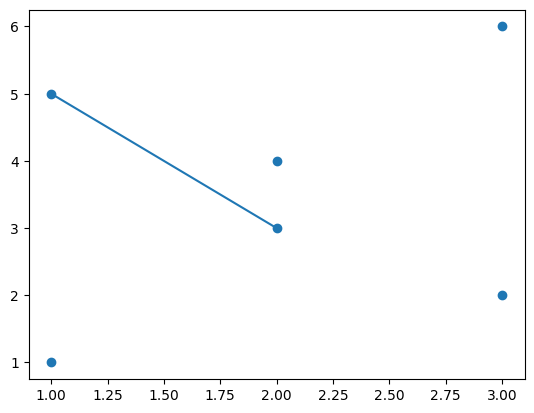

In [18]:
# Function to check if a string has a number in it
def containsNumber(value) -> Iterable[int]:
    """ Checks if value contains a number and
    returns a Iterable of numbers in the value.

    Parameters
    ----------
    `value` (str):
        The string to check.

    Returns
    -------
    `num_list` (Iterable[int]):
        The list of numbers in the value.
    """
    # Find the numbers from the string
    return [(int(num)-1) for num in re.findall(r'\d+', value)]

sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

You predicted that, didn't you? Well that shows you understand how this works! Now we're going to take this a step further, to really bring put the model to use. We are going to have a rather random graph, where some nodes will not have an edge directly connecting them. The goal for the model is to find a path such that it connects the source and destination by using these intermediate nodes as steps, and doing so with optimal cost.

We will repeat the same process, but this time with a different graph. This forces us to alter the loops as well to account for this change.

In [32]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

# Initializing the objective
objective = 0

# Initializing the constraints
constraint_1 = 0
constraint_2 = 0

Here is where we define the edges.

In [33]:
edges = [[0, 1], [1, 2], [1, 3], [1, 5], [2, 3], [3, 4], [4, 5]]

s = 2
t = 4

graph.set_edges(edges=edges)

We don't need to change the distance matrix, as we will access the distances we need based on the `edges` list.

In [34]:
X = np.array([])

for i in range(n):
    for j in range(n):
        if [i, j] in edges:
            X = np.append(X, Binary(f"X_{i+1}_{j+1}"))
        else:
            X = np.append(X, 0)
X = X.reshape(n, n)

print(X)

[[0.0 BinaryQuadraticModel({'X_1_2': 1.0}, {}, 0.0, 'BINARY') 0 0 0 0]
 [0 0 BinaryQuadraticModel({'X_2_3': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_4': 1.0}, {}, 0.0, 'BINARY') 0
  BinaryQuadraticModel({'X_2_6': 1.0}, {}, 0.0, 'BINARY')]
 [0 0 0 BinaryQuadraticModel({'X_3_4': 1.0}, {}, 0.0, 'BINARY') 0 0]
 [0 0 0 0 BinaryQuadraticModel({'X_4_5': 1.0}, {}, 0.0, 'BINARY') 0]
 [0 0 0 0 0 BinaryQuadraticModel({'X_5_6': 1.0}, {}, 0.0, 'BINARY')]
 [0 0 0 0 0 0]]


In [35]:
# Defining objective
objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
cqm.set_objective(objective)

In [36]:
# Defining the constraints
for i in range(n):
	constraint_1 = quicksum(X[i][j] for j in range(n)) - quicksum(X[j][i] for j in range(n))
	print(f"Constraint 1-{i+1}")
	if i == s:
		cqm.add_constraint(constraint_1 == 1, label=f"constraint 1-{i+1}")
	elif i == t:
		cqm.add_constraint(constraint_1 == -1, label=f"constraint 1-{i+1}")
	else:
		cqm.add_constraint(constraint_1 == 0, label=f"constraint 1-{i+1}")

print(cqm.constraints["constraint 1-2"])

Constraint 1-1
Constraint 1-2
Constraint 1-3
Constraint 1-4
Constraint 1-5
Constraint 1-6
X_2_3 + X_2_4 + X_2_6 - X_1_2 == 0.0


In [37]:
for i in range(n):
	for j in range(n):
		print(f"Constraint 2-{i+1}{j+1}")
		if X[i][j] == 0:
			pass
		else:
			cqm.add_constraint(X[i][j]>= 0, label=f"constraint 2-{i+1}{j+1}")

Constraint 2-11
Constraint 2-12
Constraint 2-13
Constraint 2-14
Constraint 2-15
Constraint 2-16
Constraint 2-21
Constraint 2-22
Constraint 2-23
Constraint 2-24
Constraint 2-25
Constraint 2-26
Constraint 2-31
Constraint 2-32
Constraint 2-33
Constraint 2-34
Constraint 2-35
Constraint 2-36
Constraint 2-41
Constraint 2-42
Constraint 2-43
Constraint 2-44
Constraint 2-45
Constraint 2-46
Constraint 2-51
Constraint 2-52
Constraint 2-53
Constraint 2-54
Constraint 2-55
Constraint 2-56
Constraint 2-61
Constraint 2-62
Constraint 2-63
Constraint 2-64
Constraint 2-65
Constraint 2-66


Let's run it again.

In [38]:
# Running the sampler to get the sample set
cqm_sampler = CQMBackend(token=token, time=30, label='CQM-ESP')
sampleset = cqm_sampler(problem=cqm)

In [39]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

constraint 1-1 X_1_2 == 0.0
constraint 1-2 X_2_3 + X_2_4 + X_2_6 - X_1_2 == 0.0
constraint 1-3 X_3_4 - X_2_3 == 1.0
constraint 1-4 X_4_5 - X_2_4 - X_3_4 == 0.0
constraint 1-5 X_5_6 - X_4_5 == -1.0
constraint 1-6 -X_2_6 - X_5_6 == 0.0
constraint 2-12 X_1_2 >= 0.0
constraint 2-23 X_2_3 >= 0.0
constraint 2-24 X_2_4 >= 0.0
constraint 2-26 X_2_6 >= 0.0
constraint 2-34 X_3_4 >= 0.0
constraint 2-45 X_4_5 >= 0.0
constraint 2-56 X_5_6 >= 0.0
  X_1_2 X_2_3 X_2_4 X_2_6 X_3_4 X_4_5 X_5_6   energy num_oc. is_sat. is_fea.
0   0.0   0.0   0.0   0.0   1.0   1.0   0.0 3.650282       1 arra...    True
['INTEGER', 1 rows, 1 samples, 7 variables]

In [40]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

constraint 1-1 0.0
constraint 1-2 0.0
constraint 1-3 0.0
constraint 1-4 0.0
constraint 1-5 0.0
constraint 1-6 0.0
constraint 2-12 -0.0
constraint 2-23 -0.0
constraint 2-24 -0.0
constraint 2-26 -0.0
constraint 2-34 -1.0
constraint 2-45 -1.0
constraint 2-56 -0.0


In [41]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : -1.0
rhs : -1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 1.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 1.0
rhs : 0.0
sense  : Sense.Ge
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Ge
---


In [42]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_3_4', 'X_4_5']


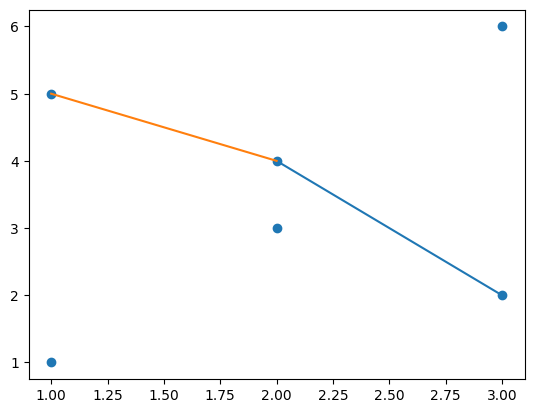

In [43]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

Now we can see the algorithm finding the path with limited access. This implementation requires $2N$ constraints, thus is a rather efficient way of implementing this problem. However, we must note that this scales linearly with more edges we have. Let's say we have a city, with 10,000 roads, then we will require 20,000 constraints.

## Constructing the QESP Solver class 

We will now construct a class for finding the shortest path between two given nodes, if one exists. This class will take in the coordinates, the edges in the graph, and the boundary nodes, and return the shortest path.

In [46]:
from __future__ import annotations

__all__ = ['QESP']

from collections.abc import Iterable
import re
import os
os.chdir('..')

import dimod
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dimod.serialization.format import Formatter

from cqm.data import Graph
from cqm.solver import CQM
from cqm.backend import CQMBackend

import numpy as np


class QESP(CQM):
    """ `QESP` is a class for implementing a CQM for the Shortest Path Finding Problem.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 edges: Iterable[Iterable[int]],
                 source: int,
                 destination: int,
                 time: int,
                 log: bool = True) -> None:
        """ Initializes a `QESP` instance.

        Parameters
        ----------
        `coordinates` (Iterable[Iterable[float]]):
            The coordinates of the nodes of the graph.
        `edges` (Iterable[Iterable[int]]):
            The edges of the graph.
        `source` (int):
            The source node.
        `destination` (int):
            The desination node.
        `time` (int):
            The time limit for the problem.
        `log` (bool):
            Whether to log the output or not.
        """
        self.graph = Graph(coordinates=coordinates,
                           edges=edges)
        self.source = source
        self.destination = destination
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_CQM(self) -> dimod.ConstrainedQuadraticModel:
        """ Defines the CQM for the given graph.

        Returns
        -------
        `cqm` (dimod.ConstrainedQuadraticModel):
            The CQM.
        """
        # Define the number of nodes
        n = self.graph.num_nodes

        # Construct the distance matrix
        distance_matrix = self.graph.calculate_distance_matrix()

        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0

        # Initialize the decision variables
        X = np.array([])

        for i in range(n):
            for j in range(n):
                if [i, j] in self.graph.edges:
                    X = np.append(X, Binary(f"X_{i+1}_{j+1}"))
                else:
                    X = np.append(X, 0)
        X = X.reshape(n, n)

        # Define objective
        objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
        cqm.set_objective(objective)

        # Define the constraints
        for i in range(n):
            constraint_1 = quicksum(X[i][j] for j in range(n)) - quicksum(X[j][i] for j in range(n))
            if i == self.source:
                cqm.add_constraint(constraint_1 == 1, label=f"constraint 1-{i+1}")
            elif i == self.destination:
                cqm.add_constraint(constraint_1 == -1, label=f"constraint 1-{i+1}")
            else:
                cqm.add_constraint(constraint_1 == 0, label=f"constraint 1-{i+1}")

        # Define subtour elimination constraint
        for i in range(n):
            for j in range(n):
                constraint_2 = X[i][j]
                if constraint_2 == 0:
                    pass
                else:
                    cqm.add_constraint(constraint_2>= 0, label=f"constraint 2-{i+1}{j+1}")

        # Return the cqm
        return cqm

    def __call__(self,
                 token: str) -> None:
        """ Solves the ESP CQM.

        Parameters
        ----------
        `token` (str):
            The token for the solver.
        """
        # Define the sampler
        cqm_sampler = CQMBackend(token=token,
                                 time=self.time_limit,
                                 label='CQM-ESP')

        # Run the sampler to get the sample set
        sampleset = cqm_sampler(problem=self.cqm)

        # If the log is active, print the constraints' data
        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        # Filter the feasible samples
        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        # Get the first sample
        sample = feasible_sampleset.first.sample

        # If the log is active, print the sample
        if self.log:
            # Use `Formatter` for better readability
            Formatter(width=1000).fprint(feasible_sampleset)

            # Print the constraints' data
            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            # Print the constraints' data
            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        # Get the sample's solution
        sample_solutions = [key for key, value in sample.items() if value == 1]

        # If the log is active, print the sample's solution
        if self.log:
            print(sample_solutions)

        def containsNumber(value) -> Iterable[int]:
            """ Checks if value contains a number and
            returns a Iterable of numbers in the value.

            Parameters
            ----------
            `value` (str):
                The string to check.

            Returns
            -------
            `num_list` (Iterable[int]):
                The list of numbers in the value.
            """
            # Find the numbers from the string
            return [(int(num)-1) for num in re.findall(r'\d+', value)]

        # Get the sample's coordinate sequence
        sample_coordinate_sequence = [containsNumber(solution) for solution in sample_solutions]

        # Update the graph
        self.graph.set_edges(sample_coordinate_sequence)

        # Plot the graph
        self.graph.plot()

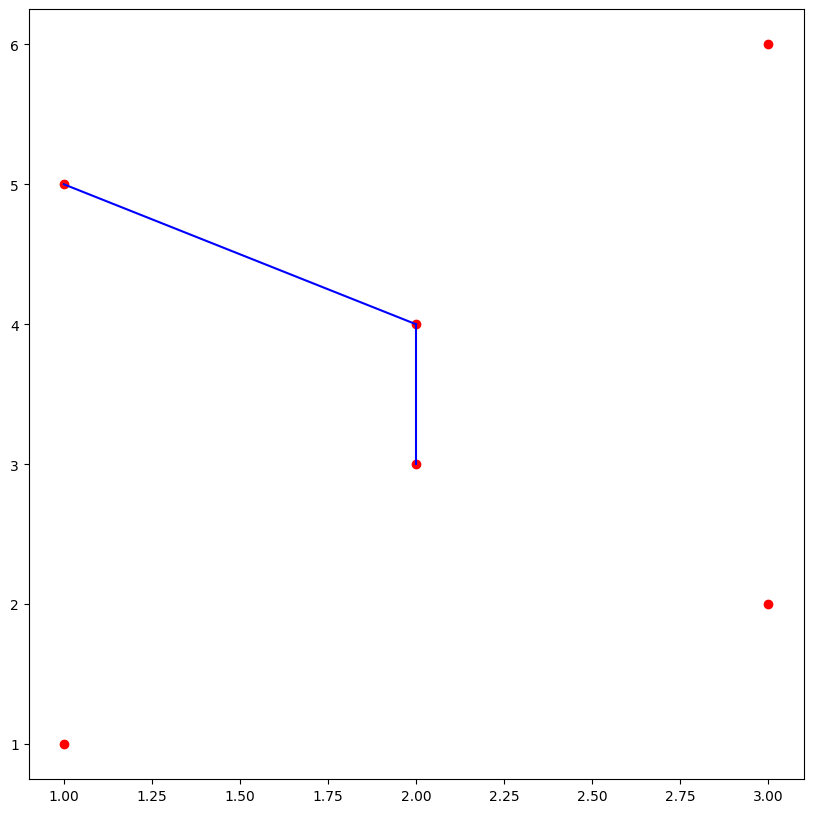

In [48]:

esp = QESP(coordinates, edges, 1, 4, 30, log=False)

esp(token)

## Final Thoughts

In this notebook, we implemented a solver for finding the shortest path between two nodes given a series of edges. The solver requires $2N$ constraints, and thus can be rather efficient for intermediate-scale problems. In a future notebook, we will explore path finding using quantum computing in other approaches besides QUBO, i.e., Grover Search.

<br>

<p>© 2023 Amirali Malekani Nezhad, all rights reserved.</p>

